In [133]:
# numerical fun with Brady, Georgia and Markus
# insert comments and notes in this cell

In [180]:
# import packages

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [189]:
# define parameters

# We solve the PDE on $[0,1]^2 \times [0,T]$

N = 50 # we assume M = N and the index for our spatial points goes 0,...,N+1, so 1,...,N are the inner spatial points
h = 1/(N+1) # spatial step size

T = 1
N_time = 1000 # the index for our time points goes 0,...,N_time + 1, so 1,...,N_time are the inner time points
tau = T/(N_time + 1) # temporal step size

beta = 10 # we assume beta to be positive
gamma = 10 # we assume gamma to be positive


In [182]:
# define initial and coefficient functions for PDE

def alpha(x,y):
    """alpha must be a continuous and strictly positive function on Omega = [0,1]^2 """
    
    #val = (x-1)**2 + (y-1)**2 + 1
    
    val = 1
    
    return val

def v_0(x,y):
    """initial function for v at t = 0. we assume that v_0 is C^1 on Omega = [0,1]^2"""
    
    val = (x-0.5)**2 + (y-0.5)**2
    
    #val = 1
    
    return val
    

In [183]:
# define main functions

def cart_coord(m, n, t, h = h, tau = tau):
    """Get cartesian coordinates from indices"""
    
    x = h*m
    y = h*n
    tt = tau*t
    
    return (x,y,tt)

def solve_pde(N = N, T = T, N_time = N_time, beta = beta, gamma = gamma, alpha = alpha, v_0 = v_0):
    
    # define spatial and temporal stepsize
    h = 1/(N+1)
    tau = T/(N_time + 1)
    
    # preallocate list, will be filled with matrices, each matrix corresponding to one spatial slice at constant t
    pde_solution = [None]*(N_time + 2)
    
    # compute solutions by stepping through time
    for t in range(N_time + 2):
        
        
        # compute initial values at t = 0 via v_0
        if t == 0:
            S_current = np.zeros((N+2,N+2))
            for m in range(N+2):
                for n in range(N+2):
                    (x,y,tt) = cart_coord(m = m, n = n, t = t, h = h, tau = tau)
                    S_current[m,n] = v_0(x,y)
            
            # save current solution
            pde_solution[t] = S_current
            
        
        # initialize our scheme with forward difference quotient in time
        elif t == 1:
            
            # compute inner spatial points for t = 1
            
            S_current = np.zeros((N+2,N+2))
            S_old = pde_solution[t-1]
            
            for m in range(1,N+1):
                for n in range(1,N+1):
                    
                    (x,y,tt) = cart_coord(m = m, n = n, t = t, h = h, tau = tau)
                    (x_plus,y_plus,tt) = cart_coord(m = m + 1, n = n + 1, t = t, h = h, tau = tau)
                    (x_minus, y_minus, tt) = cart_coord(m = m - 1, n = n - 1, t = t, h = h, tau = tau)
                    
                    A = alpha(x,y)*(S_old[m+1,n] + S_old[m-1,n] - 4*S_old[m,n] + S_old[m,n+1] + S_old[m,n-1])
                    
                    B = (1/4)*(alpha(x_plus,y) - alpha(x_minus,y))*(S_old[m+1,n] - S_old[m-1,n])
                    
                    C = (1/4)*(alpha(x,y_plus) - alpha(x,y_minus))*(S_old[m,n+1]-S_old[m,n-1])
                    
                    bracket = A + B + C
                    
                    S_current[m,n] = S_old[m,n] + (tau/(gamma*(h**2))) * bracket
                    
            
            # compute boundary values using boundary condition
            
            for n in range(1,N+1):
                (x,y,tt) = cart_coord(m = 0, n = n, t = t, h = h, tau = tau)
                S_current[0,n] = -(S_current[2,n] - 4*S_current[1,n])/(3 + (2*h*beta/alpha(0,y)))
                S_current[N+1,n] = (4*S_current[N,n] - S_current[N-1,n])/(3 + (2*h*beta/alpha(N+1,y)))
            
            for m in range(1,N+1):
                (x,y,tt) = cart_coord(m = m, n = 0, t = t, h = h, tau = tau)
                S_current[m,0] = -(S_current[m,2] - 4*S_current[m,1])/(3 + (2*h*beta/alpha(x,0)))
                S_current[m,N+1] = (4*S_current[m,N] - S_current[m,N-1])/(3 + (2*h*beta/alpha(x,N+1)))
            
            
            # compute values at the four corners averaging their three neighbours
            
            S_current[0,0] = (S_current[0,1] + S_current[1,0] + S_current[1,1])/3
            S_current[0, N+1] = (S_current[1,N+1] + S_current[0,N] + S_current[1,N])/3
            S_current[N+1,0] = (S_current[N,0] + S_current[N+1,1] + S_current[N,1])/3
            S_current[N+1,N+1] = (S_current[N,N+1] + S_current[N+1,N] + S_current[N,N])/3
            
            # save current solution
            pde_solution[t] = S_current
        
        
        else:
                        
            # compute inner spatial points for t (with t>1)
            
            S_current = np.zeros((N+2,N+2))
            S_old = pde_solution[t-1]
            S_very_old = pde_solution[t-2]
            
            for m in range(1,N+1):
                for n in range(1,N+1):
                    
                    (x,y,tt) = cart_coord(m = m, n = n, t = t, h = h, tau = tau)
                    (x_plus,y_plus,tt) = cart_coord(m = m + 1, n = n + 1, t = t, h = h, tau = tau)
                    (x_minus, y_minus, tt) = cart_coord(m = m - 1, n = n - 1, t = t, h = h, tau = tau)
                    
                    A = alpha(x,y)*(S_old[m+1,n] + S_old[m-1,n] - 4*S_old[m,n] + S_old[m,n+1] + S_old[m,n-1])
                    
                    B = (1/4)*(alpha(x_plus,y) - alpha(x_minus,y))*(S_old[m+1,n] - S_old[m-1,n])
                    
                    C = (1/4)*(alpha(x,y_plus) - alpha(x,y_minus))*(S_old[m,n+1]-S_old[m,n-1])
                    
                    bracket = A + B + C
                    
                    S_current[m,n] = S_very_old[m,n] + ((2*tau)/(gamma*(h**2))) * bracket
                    
            
            # compute boundary values using boundary condition
            
            for n in range(1,N+1):
                (x,y,tt) = cart_coord(m = 0, n = n, t = t, h = h, tau = tau)
                S_current[0,n] = -(S_current[2,n] - 4*S_current[1,n])/(3 + (2*h*beta/alpha(0,y)))
                S_current[N+1,n] = (4*S_current[N,n] - S_current[N-1,n])/(3 + (2*h*beta/alpha(N+1,y)))
            
            for m in range(1,N+1):
                (x,y,tt) = cart_coord(m = m, n = 0, t = t, h = h, tau = tau)
                S_current[m,0] = -(S_current[m,2] - 4*S_current[m,1])/(3 + (2*h*beta/alpha(x,0)))
                S_current[m,N+1] = (4*S_current[m,N] - S_current[m,N-1])/(3 + (2*h*beta/alpha(x,N+1)))
            
            
            # compute values at the four corners averaging their three neighbours
            
            S_current[0,0] = (S_current[0,1] + S_current[1,0] + S_current[1,1])/3
            S_current[0, N+1] = (S_current[1,N+1] + S_current[0,N] + S_current[1,N])/3
            S_current[N+1,0] = (S_current[N,0] + S_current[N+1,1] + S_current[N,1])/3
            S_current[N+1,N+1] = (S_current[N,N+1] + S_current[N+1,N] + S_current[N,N])/3
            
            # save current solution
            pde_solution[t] = S_current

    return pde_solution

In [190]:
# compute and print solutions

pde_solution = solve_pde(N = N, T = T, N_time = N_time, beta = beta, gamma = gamma, alpha = alpha, v_0 = v_0)

for S in pde_solution:
    print(S)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in 

[[0.5        0.48077662 0.46232218 ... 0.46232218 0.48077662 0.5       ]
 [0.48077662 0.46155325 0.44309881 ... 0.44309881 0.46155325 0.48077662]
 [0.46232218 0.44309881 0.42464437 ... 0.42464437 0.44309881 0.46232218]
 ...
 [0.46232218 0.44309881 0.42464437 ... 0.42464437 0.44309881 0.46232218]
 [0.48077662 0.46155325 0.44309881 ... 0.44309881 0.46155325 0.48077662]
 [0.5        0.48077662 0.46232218 ... 0.46232218 0.48077662 0.5       ]]
[[0.42997643 0.41398822 0.39766724 ... 0.39766724 0.41398822 0.42997643]
 [0.41398822 0.46195285 0.44349841 ... 0.44349841 0.46195285 0.41398822]
 [0.39766724 0.44349841 0.42504397 ... 0.42504397 0.44349841 0.39766724]
 ...
 [0.39766724 0.44349841 0.42504397 ... 0.42504397 0.44349841 0.39766724]
 [0.41398822 0.46195285 0.44349841 ... 0.44349841 0.46195285 0.41398822]
 [0.42997643 0.41398822 0.39766724 ... 0.39766724 0.41398822 0.42997643]]
[[0.3588147  0.3419621  0.35815508 ... 0.35815508 0.3419621  0.3588147 ]
 [0.3419621  0.39251988 0.41009044 ... 

  -2.56525935e+204 -2.05337075e+204]]
[[ 8.92428752e+204  1.11490769e+205 -4.96336329e+205 ... -4.96336329e+205
   1.11490769e+205  8.92428752e+204]
 [ 1.11490769e+205  4.47470880e+204 -1.99205824e+205 ... -1.99205824e+205
   4.47470880e+204  1.11490769e+205]
 [-4.96336329e+205 -1.99205824e+205  8.86827388e+205 ...  8.86827388e+205
  -1.99205824e+205 -4.96336329e+205]
 ...
 [-4.96336329e+205 -1.99205824e+205  8.86827388e+205 ...  8.86827388e+205
  -1.99205824e+205 -4.96336329e+205]
 [ 1.11490769e+205  4.47470880e+204 -1.99205824e+205 ... -1.99205824e+205
   4.47470880e+204  1.11490769e+205]
 [ 8.92428752e+204  1.11490769e+205 -4.96336329e+205 ... -4.96336329e+205
   1.11490769e+205  8.92428752e+204]]
[[-3.87874675e+205 -4.84571895e+205  2.15730592e+206 ...  2.15730592e+206
  -4.84571895e+205 -3.87874675e+205]
 [-4.84571895e+205 -1.94480236e+205  8.65822935e+205 ...  8.65822935e+205
  -1.94480236e+205 -4.84571895e+205]
 [ 2.15730592e+206  8.65822935e+205 -3.85462835e+206 ... -3.85462835

 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan na

 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan na

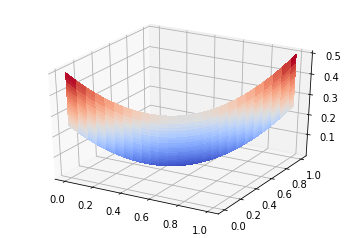

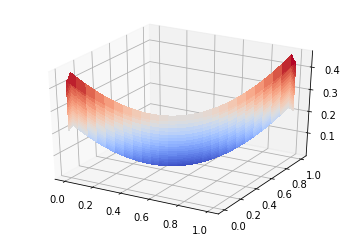

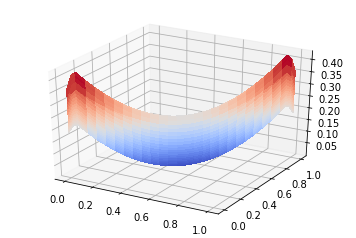

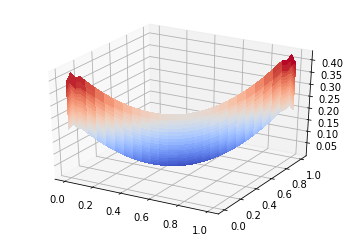

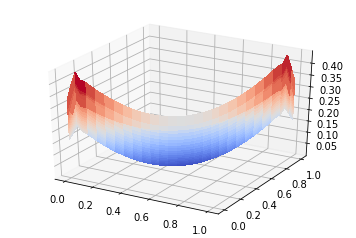

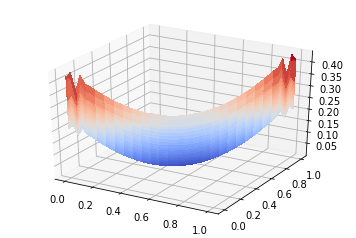

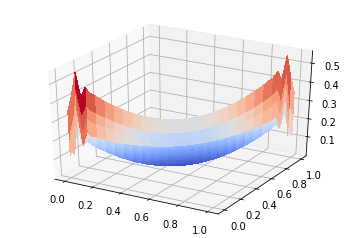

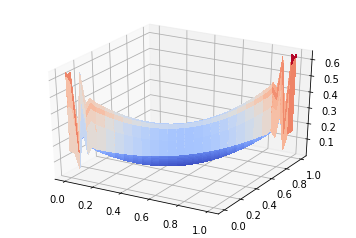

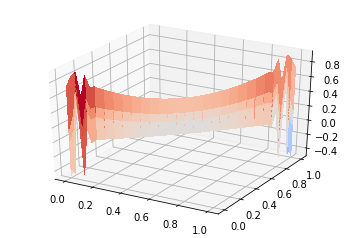

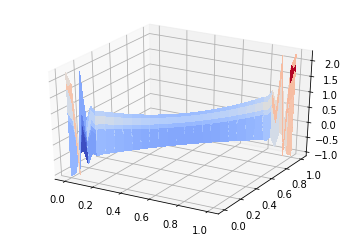

In [191]:
# plot some solutions to see what is going on

for k in range(10):   
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(0, 1+h, h)
    Y = np.arange(0, 1+h, h)

    Z = pde_solution[k]


    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    #ax.set_zlim(-2.01, 2.01)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    #fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()